In [48]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
from scipy import fftpack
import pylab as plb

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



the maximum wind speed in 50 years is predicted to be: 33.99121541124585


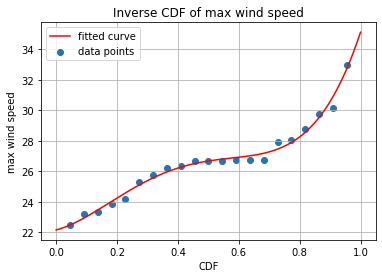

In [2]:
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
cprob = np.arange(1,years_nb+1)/(years_nb+1)
max_speeds = np.sort(max_speeds)
quantile_func = interpolate.UnivariateSpline(cprob,max_speeds, k=4) # for better fitting
fifty_prob = 1.-0.02
fifty_wind = quantile_func(fifty_prob)
print("the maximum wind speed in 50 years is predicted to be:", fifty_wind)

fig,ax = plt.subplots()
x=np.linspace(0,1,1000)
ax.scatter(cprob, max_speeds, label="data points", )
ax.plot(x,quantile_func(x), label="fitted curve", c="Red")

ax.set_title("Inverse CDF of max wind speed")
ax.set_xlabel("CDF")
ax.set_ylabel("max wind speed")
ax.grid()
ax.legend();

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

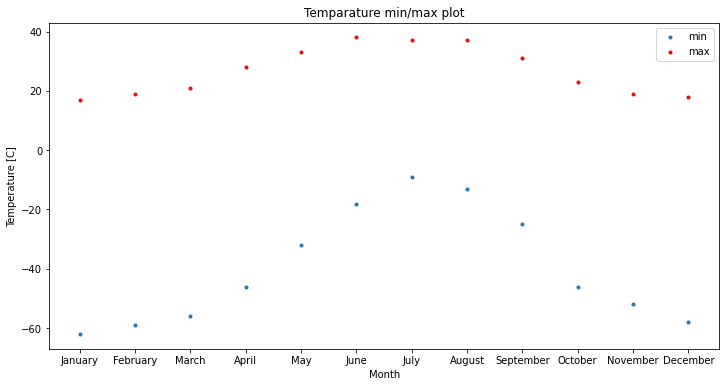

In [391]:
index = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
max = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])

data = pd.DataFrame(data=np.array([min,max]).T, index=index, columns=["min", "max"])
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(data.index,data["min"],label="min", marker=".")
ax.scatter(data.index,data["max"], c="Red", label ="max", marker=".")
ax.set_title("Temparature min/max plot")
ax.set_xlabel("Month")
ax.set_ylabel("Temperature [C]")
ax.legend();

phi_max = 2.894 phi_min = 2.595
phi_max_std = 0.126 phi_mix_std = 0.143
lambda = 1.565
% diff 11.5
time offset difference in days: 12.2


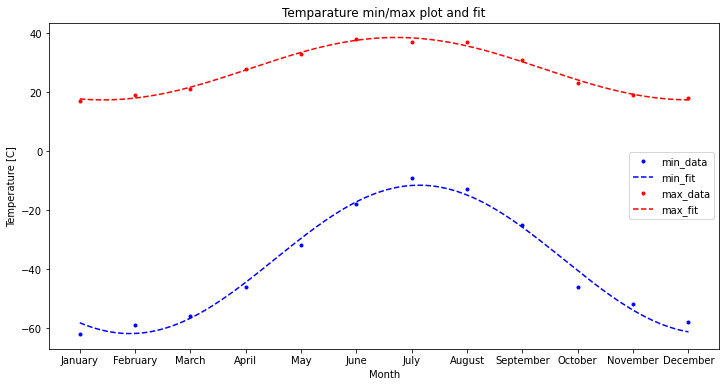

In [466]:
def f(x, A, k, phi, c):
    return A*np.cos(k*x+phi)+c

x = np.arange(0,12)
max_f = optimize.curve_fit(f,x,data["max"],[5,1,1,30])
par_max= max_f[0]
cov_max = max_f[1]
min_f = optimize.curve_fit(f,x,data["min"],[50,1,1,-35])
par_min = min_f[0]
cov_min = min_f[1]

x_plot=(np.linspace(0,11,1000))
fig2, ax2 = plt.subplots(figsize=(12,6))
ax2.plot(x, data["min"], 'b.', label="min_data")
ax2.plot(x_plot, f(x_plot,par_min[0],par_min[1],par_min[2], par_min[3]),"b--", label='min_fit')
ax2.plot(x, data["max"], 'r.', label="max_data")
ax2.plot(x_plot, f(x_plot,par_max[0],par_max[1],par_max[2], par_max[3]),"r--", label='max_fit')
ax2.set_xticks(x)
ax2.set_xticklabels(data.index)
ax2.legend(loc='center right')
ax2.set_title("Temparature min/max plot and fit")
ax2.set_xlabel("Month")
ax2.set_ylabel("Temperature [C]")

print("phi_max =", '{:.3f}'.format(par_max[2]), "phi_min =",'{:.3f}'.format(par_min[2]))
print("phi_max_std =", '{:.3f}'.format(np.sqrt(np.diag(cov_max))[2]),"phi_mix_std =", '{:.3f}'.format(np.sqrt(np.diag(cov_min))[2]))
print("lambda =", '{:.3f}'.format(np.abs(par_max[2]-par_min[2])/np.sqrt(np.diag(cov_max)[2]+np.diag(cov_min)[2])))
print("% diff", '{:.1f}'.format(100*(par_max[2]-par_min[2])/par_min[2]))

peak_diff = x_plot[np.argmax(f(x_plot,par_min[0],par_min[1],par_min[2], par_min[3]))]-x_plot[np.argmax(f(x_plot,par_max[0],par_max[1],par_max[2], par_max[3]))]
print("time offset difference in days:", '{:.1f}'.format(peak_diff*30))


The time offset is represented by the phi parameter (the k parameter can be neglected since his values for the min and the max curve are really close). The compatibility (lambda) of the two parameters is not optimal (>1) and the difference in values translates in about a 12 days offset between the two peaks

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


method used:  Nelder-Mead
Start point: [0, 1]
fun: -1.0316284502592377 x: [-0.08984945  0.71267605]  

Start point: [0, -1]
fun: -1.031628450217692 x: [ 0.08984807 -0.71267632]  

Start point: [2, -0.8]
fun: -0.21546380708773039 x: [ 1.70359519 -0.79612087]  

Start point: [-2, 0.8]
fun: -0.21546380708773039 x: [-1.70359519  0.79612087]  

Start point: [0, 0]
fun: -1.031628452567338 x: [-0.08985145  0.71266538]  




method used:  CG
Start point: [0, 1]
fun: -1.0316284534898714 x: [-0.08984198  0.71265639]  

Start point: [0, -1]
fun: -1.0316284534898712 x: [ 0.08984197 -0.71265639]  

Start point: [2, -0.8]
fun: -1.0316284534897167 x: [ 0.08984218 -0.71265633]  

Start point: [-2, 0.8]
fun: -1.0316284534897167 x: [-0.08984218  0.71265633]  

Start point: [0, 0]
fun: 0.0 x: [0. 0.]  




method used:  Powell
Start point: [0, 1]
fun: -1.0316284534898585 x: [ 0.08984201 -0.71265645]  

Start point: [0, -1]
fun: -1.0316283196776428 x: [ 0.08985124 -0.71278463]  

Start point: [2, -0.8]
fu

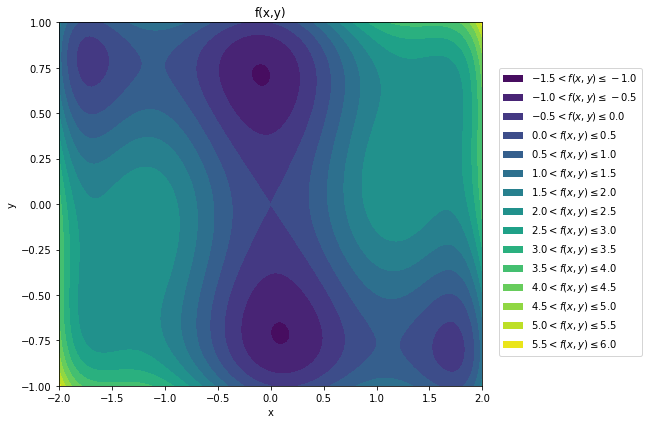

In [36]:
def f(x):
    return (4. - 2.1*x[0]**2 + x[0]**4/3)*x[0]**2 + x[0]*x[1] + (4*x[1]**2 - 4)*x[1]**2

x = np.linspace(-2,2,2000)
y = np.linspace(-1,1,1000)
xv, yv = np.meshgrid(x,y)

fig, ax = plt.subplots(figsize=(9,6))
contr = ax.contourf(x,y, f([xv,yv]),15)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("f(x,y)")
h,l = contr.legend_elements("f(x,y)")
fig.legend(h,l, loc="right")
fig.tight_layout()
fig.subplots_adjust(right=0.75)

for method in ["Nelder-Mead", "CG", "Powell", "SLSQP", "TNC"]:
    print("method used: ", method)
    for start_point in [[0,1],[0,-1],[2,-0.8],[-2,0.8], [0,0]]:
        print("Start point:", start_point)
        solutions = optimize.minimize(f, x0=start_point, method=method)
        print("fun:",solutions.fun,"x:", solutions.x, " \n")
   
    print("\n\n")



Depending on the method used the algorithm converges to one of the two global minima (which one depends on the starting point). Some methods fail to reach the global minima and stop on a local minima. When starting on (0,0) some methods are stuck there (the function and the gradient are null) while others reach the global minima.

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

Periodicity of lynxes population: 10.5
Periodicity of hares population: 10.5
Reasonable result, but we can be more precise
Periodicity of lynxes population (with iterpolation): 10.0
Periodicity of hares population (with interpolation): 10.0


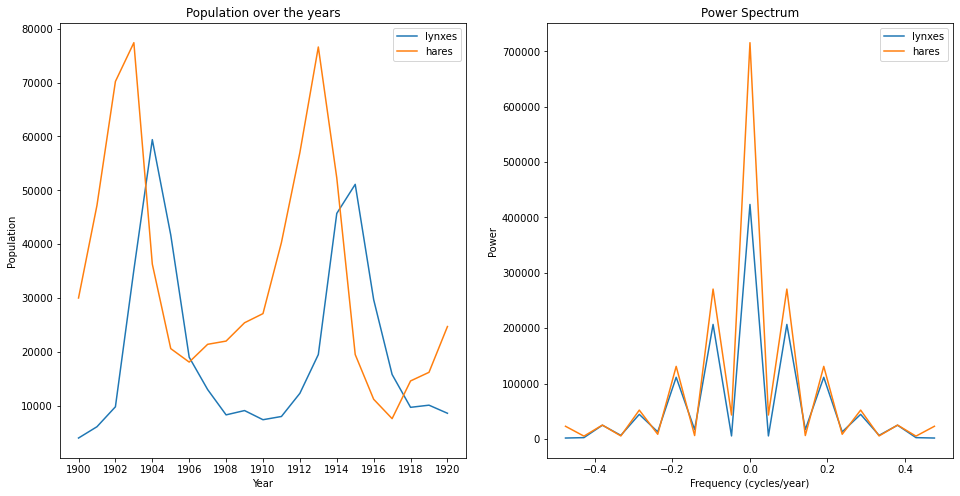

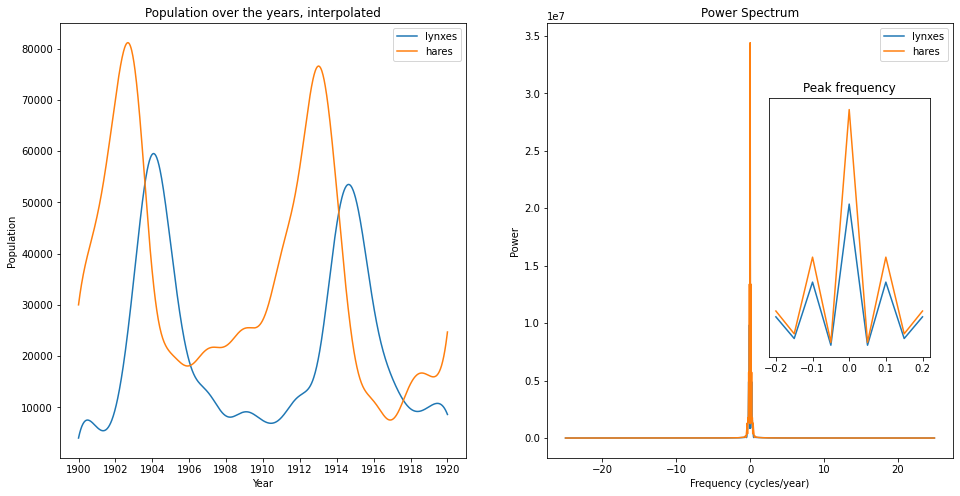

In [390]:
data = np.loadtxt("populations.txt",dtype=int)
year, hares, lynxes, carrots = tuple((data[::,i] for i in range(data.shape[1])))

fig,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(year, lynxes, label='lynxes')
ax[0].plot(year, hares, label='hares')
ax[0].legend()
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Population")
ax[0].set_title("Population over the years")
ax[0].xaxis.set_ticks(np.arange(year[0],year[-1]+1,2))

lynxes_fft=fftpack.fft(lynxes)
lynxes_fft = fftpack.fftshift(lynxes_fft)
lynxes_power = np.abs(lynxes_fft)

hares_fft=fftpack.fft(hares)
hares_fft = fftpack.fftshift(hares_fft)
hares_power = np.abs(hares_fft)

sample_freq = fftpack.fftfreq(lynxes.size, d=1)
sample_freq = np.sort(sample_freq)

ax[1].plot(sample_freq,lynxes_power,label='lynxes')
ax[1].plot(sample_freq,hares_power,label='hares')
ax[1].legend()
ax[1].set_xlabel("Frequency (cycles/year)")
ax[1].set_ylabel("Power")
ax[1].set_title("Power Spectrum")

print("Periodicity of lynxes population:", 1/sample_freq[sample_freq>0][np.argmax(lynxes_power[sample_freq>0])])
print("Periodicity of hares population:", 1/sample_freq[sample_freq>0][np.argmax(hares_power[sample_freq>0])])

print("Reasonable result, but we can be more precise")

#interpolation of data points with spline

fig2, ax2 = plt.subplots(1,2,figsize=(16,8))
hares_curve = interpolate.UnivariateSpline(year,hares, k=4)
lynxes_curve = interpolate.UnivariateSpline(year,lynxes,k=4)
t_sample=np.linspace(year[0],year[-1],1000)

ax2[0].plot(t_sample,lynxes_curve(t_sample), label='lynxes')
ax2[0].plot(t_sample,hares_curve(t_sample), label='hares')
ax2[0].legend()
ax2[0].set_xlabel("Year")
ax2[0].set_ylabel("Population")
ax2[0].set_title("Population over the years, interpolated")
ax2[0].xaxis.set_ticks(np.arange(year[0],year[-1]+1,2))


lynxes_fft = fftpack.fft(lynxes_curve(t_sample))
lynxes_fft = fftpack.fftshift(lynxes_fft)
lynxes_power = np.abs(lynxes_fft)

hares_fft = fftpack.fft(hares_curve(t_sample))
hares_fft = fftpack.fftshift(hares_fft)
hares_power = np.abs(hares_fft)

sample_freq = fftpack.fftfreq(lynxes_fft.size, d=20/1000)
sample_freq = np.sort(sample_freq)

ax2[1].plot(sample_freq,lynxes_power,label='lynxes')
ax2[1].plot(sample_freq,hares_power,label='hares')
ax2[1].legend()
ax2[1].set_xlabel("Frequency (cycles/year)")
ax2[1].set_ylabel("Power")
ax2[1].set_title("Power Spectrum")
iax = plt.axes([0.74,0.3,0.14,0.45])
iax.plot(sample_freq[sample_freq.size//2-4:sample_freq.size//2+5],lynxes_power[sample_freq.size//2-4:sample_freq.size//2+5])
iax.plot(sample_freq[sample_freq.size//2-4:sample_freq.size//2+5],hares_power[sample_freq.size//2-4:sample_freq.size//2+5])
iax.set_title("Peak frequency")
iax.yaxis.set_ticks([])


print("Periodicity of lynxes population (with iterpolation):", 1/sample_freq[sample_freq>0][np.argmax(lynxes_power[sample_freq>0])])
print("Periodicity of hares population (with interpolation):", 1/sample_freq[sample_freq>0][np.argmax(hares_power[sample_freq>0])])



## 5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

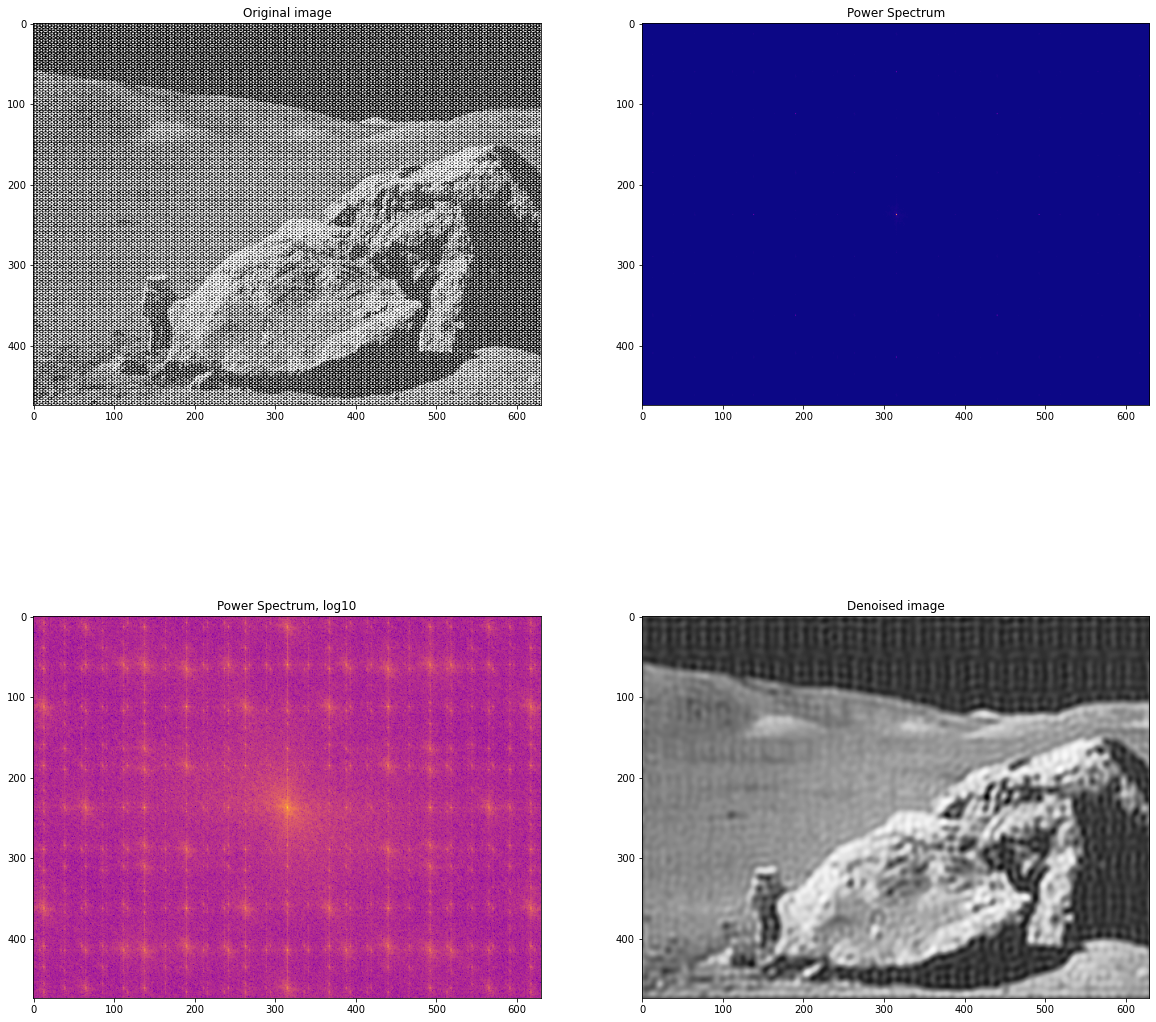

In [251]:
from matplotlib.colors import LogNorm

data = plb.imread("moonlanding.png")
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,20))
ax[0,0].imshow(data, cmap="Greys_r")
ax[0,0].set_title("Original image")

noise_level = 1000
data_fft = fftpack.fft2(data)
#shift lower frequency to center of image
data_fft = fftpack.fftshift(data_fft)
power = np.abs(data_fft)
ax[0,1].imshow(power,cmap="plasma")
ax[0,1].set_title("Power Spectrum")
ax[1,0].imshow(np.log10(power), cmap="plasma")
ax[1,0].set_title("Power Spectrum, log10")

#elipse mask
# with these values good balance between noise reduction and blur of image
r,c = data_fft.shape
r_r = 40
r_c = 60
mask = np.zeros_like(data_fft)
for i in range(r):
    for j in range(c):
        if (i-r//2)**2/(r_r**2)+(j-c//2)**2/(r_c**2) <=1:
            mask[i,j] = 1

cleaned = data_fft*mask

cleaned = fftpack.ifftshift(cleaned)
ax[1,1].imshow(np.real(fftpack.ifft2(cleaned)), cmap="Greys_r")
ax[1,1].set_title("Denoised image");



There is still some horizontal noise (probably it could be better with a different shape or a rotated ellipse). To see the spectrum cleary it is necessary to plot the log10, due to its high variability (5 order of magnitude)